# TTA Evaluation

This notebook compares raw vs. Test-Time Augmentation (TTA) performance of four ConvNeXt models on CT slice datasets (nodule vs. full; 5-class vs. 2-class). It:

- Loads test splits and prints shapes.
- Loads each pre-trained Keras model.
- Runs raw inference and multiple augmented inferences.
- Computes Accuracy, Balanced Accuracy, Weighted F1, and Weighted AUPRC.
- Displays confusion matrices and a bar chart comparing raw vs. TTA results.

## Imports

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             average_precision_score, confusion_matrix,
                             ConfusionMatrixDisplay)
from tensorflow.keras.preprocessing.image import apply_affine_transform

## Load Data

In [ ]:
def load_print_merge(npz_path, mode):
    data = np.load(npz_path)
    print(f"Shapes of {mode}:")
    for key, arr in data.items():
        print(f"  {key}: {arr.shape}")
    return (
        data['X_train'], data['y_train'],
        data['X_val'],   data['y_val'],
        data['X_test'],  data['y_test']
    )

_, _, _, _, X_test_nod5, y_test_nod5 = load_print_merge(
    '/kaggle/input/nod5_mix.npz', 'Nod5')
_, _, _, _, X_test_nod2, y_test_nod2 = load_print_merge(
    '/kaggle/input/nod2_trad.npz', 'Nod2')
_, _, _, _, X_test_full5, y_test_full5 = load_print_merge(
    '/kaggle/input/full5_mix.npz', 'Full5')
_, _, _, _, X_test_full2, y_test_full2 = load_print_merge(
    '/kaggle/input/full2_trad.npz', 'Full2')

Shapes of Nod5:
  X_train: (4365, 224, 224)
  y_train: (4365,)
  X_val: (237, 224, 224)
  y_val: (237,)
  X_test: (237, 224, 224)
  y_test: (237,)
Shapes of Nod2:
  X_train: (2866, 224, 224)
  y_train: (2866,)
  X_val: (237, 224, 224)
  y_val: (237,)
  X_test: (237, 224, 224)
  y_test: (237,)
Shapes of Full5:
  X_train: (4365, 224, 224)
  y_train: (4365,)
  X_val: (237, 224, 224)
  y_val: (237,)
  X_test: (237, 224, 224)
  y_test: (237,)
Shapes of Full2:
  X_train: (2866, 224, 224)
  y_train: (2866,)
  X_val: (237, 224, 224)
  y_val: (237,)
  X_test: (237, 224, 224)
  y_test: (237,)


## Load Models

In [ ]:
def load_best_model(filepath) -> tf.keras.Model:
    model = tf.keras.models.load_model(filepath, compile=True)
    return model

model_nod5 = load_best_model("/kaggle/input/best_model_overall_conservative_nod5.keras")
model_nod2 = load_best_model("/kaggle/input/best_model_overall_conservative_nod2.keras")
model_full5 = load_best_model("/kaggle/input/best_model_overall_moderate_full5.keras")
model_full2 = load_best_model("/kaggle/input/best_model_overall_moderate_full2.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 328 variables whereas the saved optimizer has 332 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 332 variables whereas the saved optimizer has 336 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## TTA

In [ ]:
# --- 0) Augmentation layers (unchanged) ---
rot_layer = tf.keras.layers.RandomRotation(15/360, fill_mode='nearest')
flip_layer = tf.keras.layers.RandomFlip(mode='horizontal')
zoom_layer = tf.keras.layers.RandomZoom(
    height_factor=(-0.2, 0.0),
    width_factor=(-0.2, 0.0),
    fill_mode='nearest'
)
contrast_layer = tf.keras.layers.RandomContrast(0.1)


def zero_base_labels(y: np.ndarray) -> np.ndarray:
    """Shift y so its minimum is 0 (if not already)."""
    y_min = y.min()
    return y - y_min if y_min != 0 else y


def gray_to_rgb(arr: np.ndarray) -> np.ndarray:
    """Convert grayscale image(s) to 3‐channel float32."""
    if arr.ndim == 2:
        arr = arr[..., None]
    if arr.shape[-1] == 1:
        arr = np.repeat(arr, 3, axis=-1)
    return arr.astype("float32")


def prepare_rgb_images(X: np.ndarray) -> np.ndarray:
    """Apply gray_to_rgb to every image in X."""
    return np.stack([gray_to_rgb(img) for img in X], axis=0)


def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray, probs: np.ndarray):
    """Return (acc, balanced_acc, f1_weighted, auprc_weighted)."""
    acc = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average="weighted")
    auprc = average_precision_score(
        tf.one_hot(y_true, depth=probs.shape[1]).numpy(),
        probs, average="weighted"
    )
    return acc, bacc, f1w, auprc


def raw_prediction(model, X_rgb: np.ndarray, batch_size: int):
    """Get raw probs and preds, and print metrics."""
    X_in = tf.keras.applications.convnext.preprocess_input(X_rgb)
    print("Running raw prediction…")
    probs = model.predict(X_in, batch_size=batch_size, verbose=1)
    preds = np.argmax(probs, axis=1)
    return probs, preds


def tta_prediction(model, X_rgb: np.ndarray, layers: list, batch_size: int):
    """Accumulate predictions over TTA layers and compute avg probs & preds."""
    probs_accum = None
    print("\nRunning TTA prediction…")
    for layer in layers:
        batch = X_rgb.copy() if layer is None else layer(X_rgb, training=True).numpy()
        batch_in = tf.keras.applications.convnext.preprocess_input(batch)
        probs = model.predict(batch_in, batch_size=batch_size, verbose=1)
        probs_accum = probs if probs_accum is None else probs_accum + probs

    probs_avg = probs_accum / len(layers)
    preds = np.argmax(probs_avg, axis=1)
    return probs_avg, preds


def plot_confusion_matrices(y_true, y_raw_pred, y_tta_pred):
    """Side‐by‐side confusion matrices for raw vs TTA."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    for ax, y_pred, title in zip(axes, [y_raw_pred, y_tta_pred], ["Raw", "TTA"]):
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_true))
        disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
        ax.set_title(f"{title} – Confusion Matrix")
        ax.set_xlabel("Predicted label")
        ax.set_ylabel("True label")
    plt.tight_layout()


def plot_performance_comparison(raw_vals, tta_vals):
    """Bar chart comparing the four metrics."""
    metrics = ["Accuracy", "Balanced Acc.", "Weighted F1", "Weighted AUPRC"]
    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    bars_raw = ax.bar(x - width/2, raw_vals, width, label="Raw", alpha=0.5)
    bars_tta = ax.bar(x + width/2, tta_vals, width, label="TTA", alpha=0.5)

    for bar in bars_raw + bars_tta:
        h = bar.get_height()
        ax.annotate(f"{h:.3f}",
                    xy=(bar.get_x() + bar.get_width()/2, h),
                    xytext=(0, 3), textcoords="offset points",
                    ha="center", va="bottom")

    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=30, ha="right")
    ax.set_ylabel("Score")
    ax.set_title("Raw vs. TTA Performance")
    ax.grid(True, axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
    ax.set_axisbelow(True)
    ax.legend()
    plt.tight_layout()
    plt.show()


def evaluate_with_tta(
    model: tf.keras.Model,
    X_test: np.ndarray,
    y_test: np.ndarray,
    batch_size: int = 32
):
    # 1) zero-base labels
    y = zero_base_labels(y_test)

    # 2) prepare RGB inputs once
    X_rgb = prepare_rgb_images(X_test)

    # 3) raw predictions & metrics
    probs_raw, y_pred_raw = raw_prediction(model, X_rgb, batch_size)
    acc_r, bacc_r, f1_r, auprc_r = compute_metrics(y, y_pred_raw, probs_raw)
    print(f"Raw →  Acc: {acc_r:.4f},  Bal. Acc: {bacc_r:.4f},  F1_w: {f1_r:.4f},  AUPRC_w: {auprc_r:.4f}")

    # 4) TTA predictions & metrics
    tta_layers = [None, rot_layer, flip_layer, zoom_layer, contrast_layer]
    probs_tta, y_pred_tta = tta_prediction(model, X_rgb, tta_layers, batch_size)
    acc_t, bacc_t, f1_t, auprc_t = compute_metrics(y, y_pred_tta, probs_tta)
    print(f"TTA →  Acc: {acc_t:.4f},  Bal. Acc: {bacc_t:.4f},  F1_w: {f1_t:.4f},  AUPRC_w: {auprc_t:.4f}")

    # 5) plots
    plot_confusion_matrices(y, y_pred_raw, y_pred_tta)
    raw_vals = [acc_r, bacc_r, f1_r, auprc_r]
    tta_vals = [acc_t, bacc_t, f1_t, auprc_t]
    plot_performance_comparison(raw_vals, tta_vals)

    return {
        "raw": {
            "accuracy": acc_r, "balanced_accuracy": bacc_r,
            "weighted_f1": f1_r, "weighted_auprc": auprc_r
        },
        "tta": {
            "accuracy": acc_t, "balanced_accuracy": bacc_t,
            "weighted_f1": f1_t, "weighted_auprc": auprc_t
        },
    }

### Nodule Slice with 5 class

Running raw prediction…
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 685ms/step
Raw →  Acc: 0.5654,  Bal. Acc: 0.4923,  F1_w: 0.5534,  AUPRC_w: 0.5493

Running TTA prediction…
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
TTA →  Acc: 0.5443,  Bal. Acc: 0.4866,  F1_w: 0.5359,  AUPRC_w: 0.5560


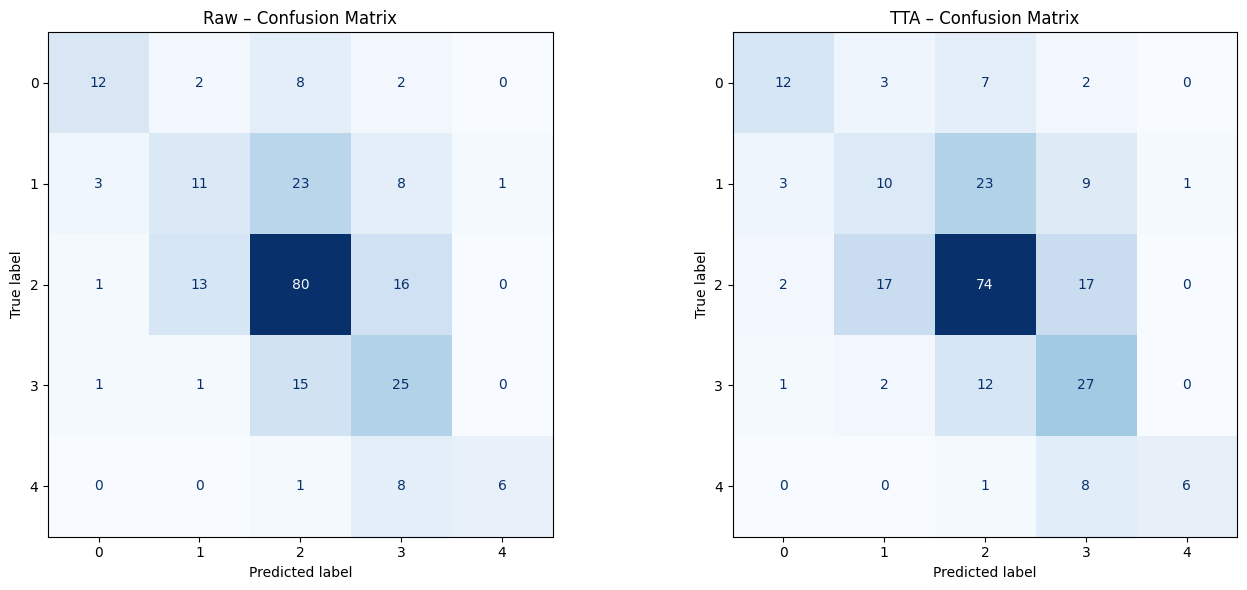

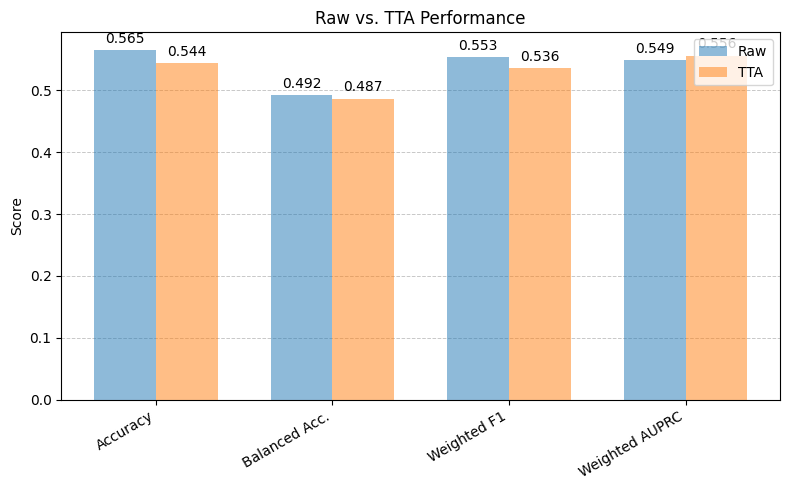

In [ ]:
metrics_nod5 = evaluate_with_tta(
    model_nod5,
    X_test_nod5, y_test_nod5,
    batch_size=32
)

### Nodule Slice with 2 class

Running raw prediction…
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 642ms/step
Raw →  Acc: 0.8228,  Bal. Acc: 0.7575,  F1_w: 0.8228,  AUPRC_w: 0.8768

Running TTA prediction…
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
TTA →  Acc: 0.7975,  Bal. Acc: 0.7708,  F1_w: 0.8052,  AUPRC_w: 0.8826


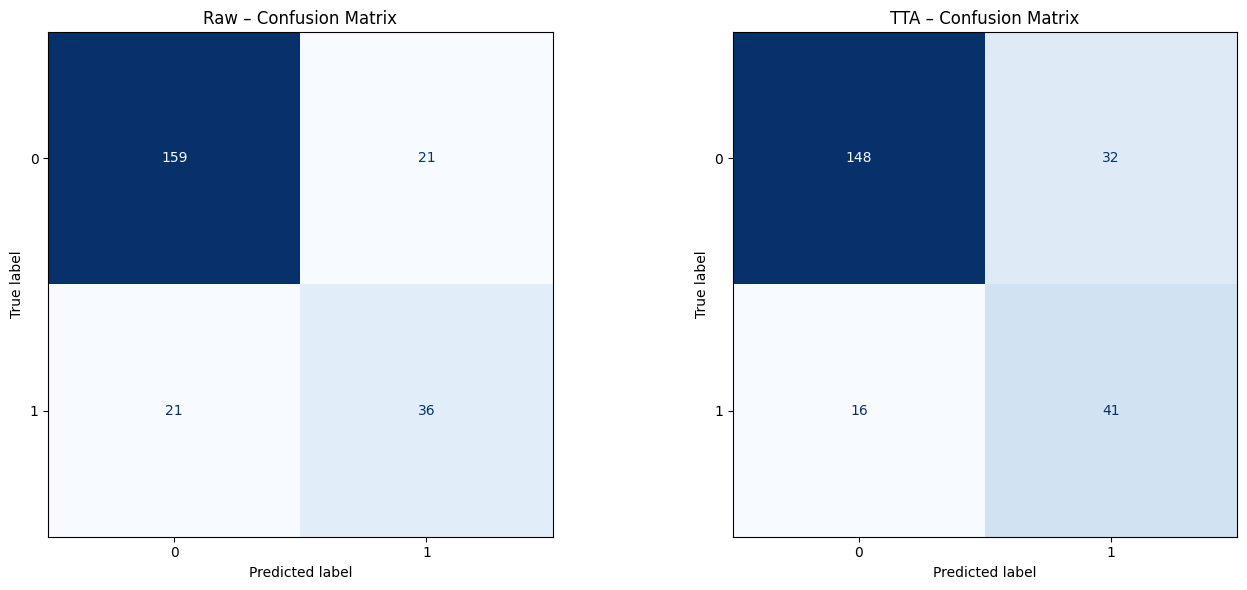

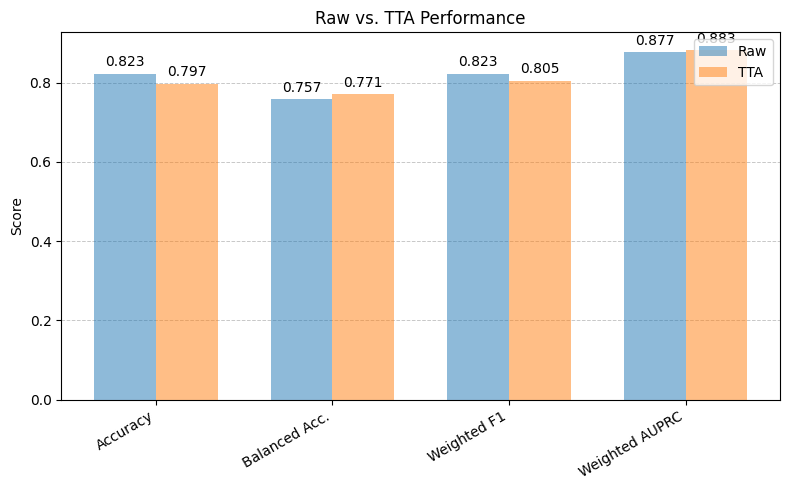

In [ ]:
metrics_nod2 = evaluate_with_tta(
    model_nod2,
    X_test_nod2, y_test_nod2,
    batch_size=32
)

### Full Slice with 5 class

Running raw prediction…
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 331ms/step
Raw →  Acc: 0.4304,  Bal. Acc: 0.2927,  F1_w: 0.3935,  AUPRC_w: 0.4072

Running TTA prediction…
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
TTA →  Acc: 0.4346,  Bal. Acc: 0.3122,  F1_w: 0.4040,  AUPRC_w: 0.4187


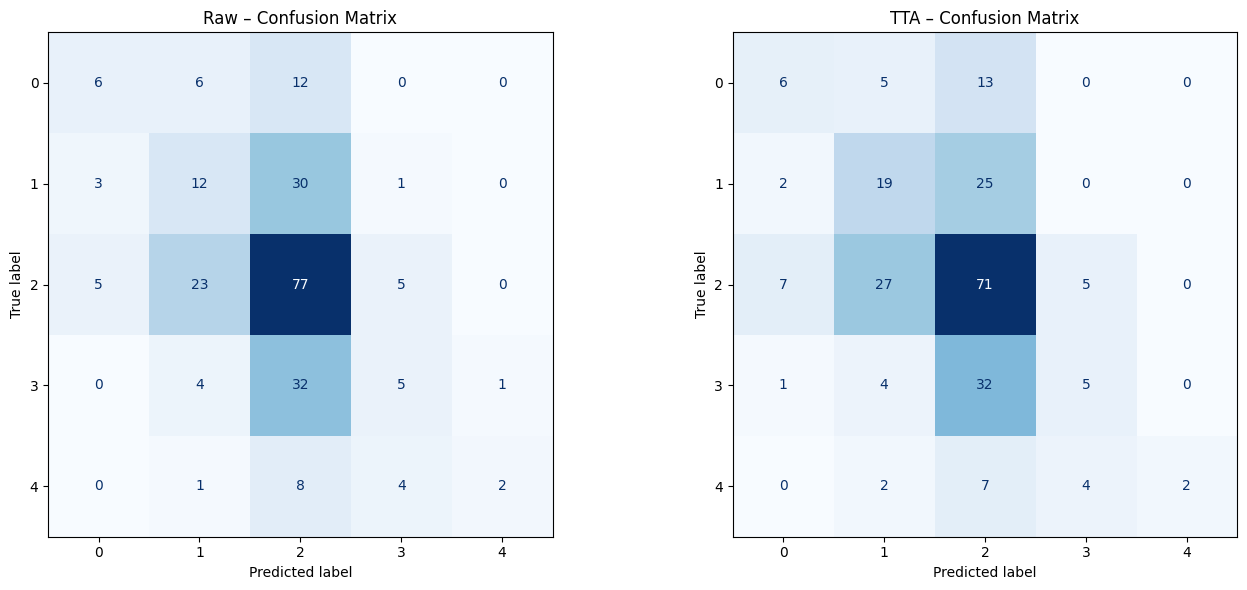

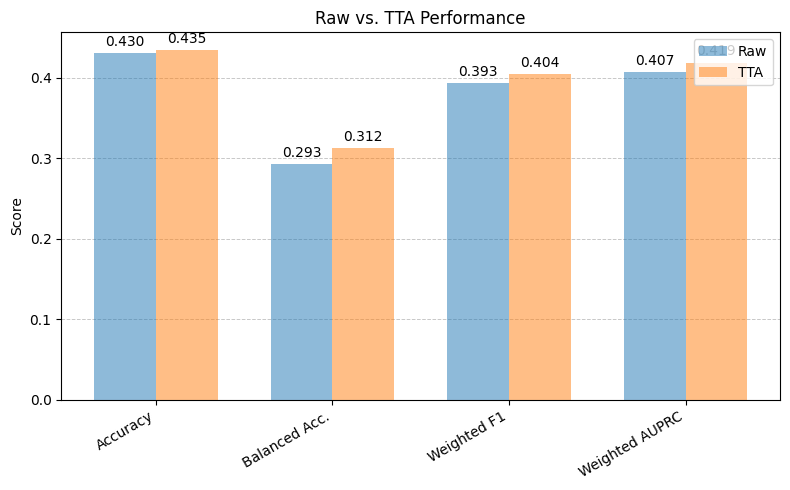

In [ ]:
metrics_full5 = evaluate_with_tta(
    model_full5,
    X_test_full5, y_test_full5,
    batch_size=16
)

### Full Slice with 2 class

Running raw prediction…
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 333ms/step
Raw →  Acc: 0.7848,  Bal. Acc: 0.6785,  F1_w: 0.7782,  AUPRC_w: 0.8050

Running TTA prediction…
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
TTA →  Acc: 0.7553,  Bal. Acc: 0.7250,  F1_w: 0.7663,  AUPRC_w: 0.8247


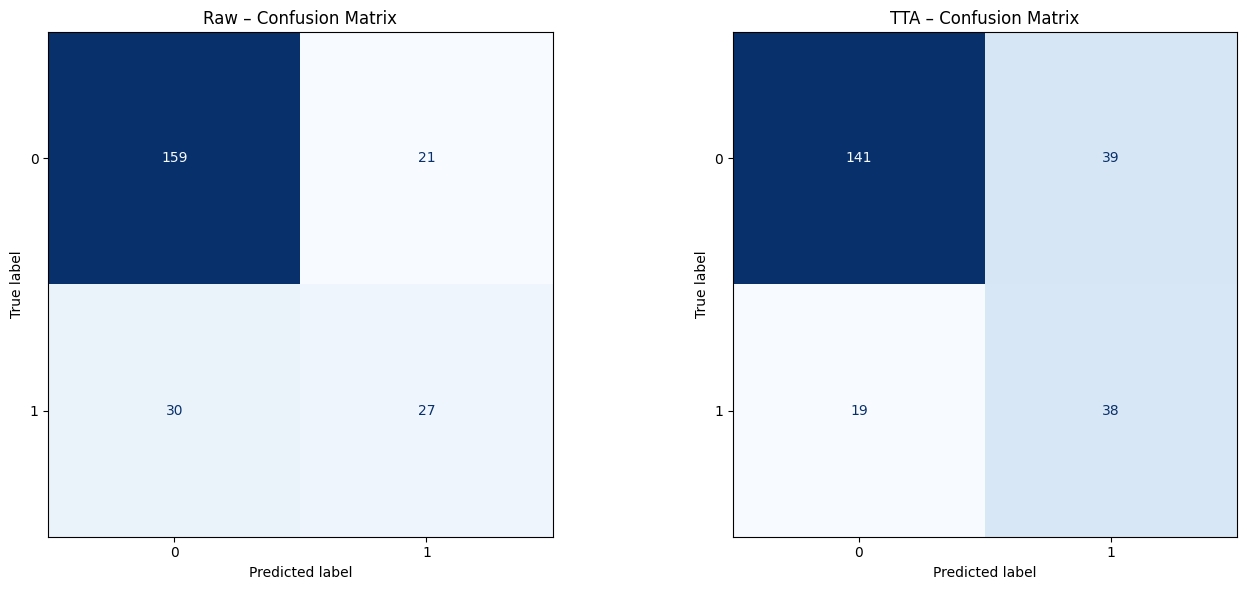

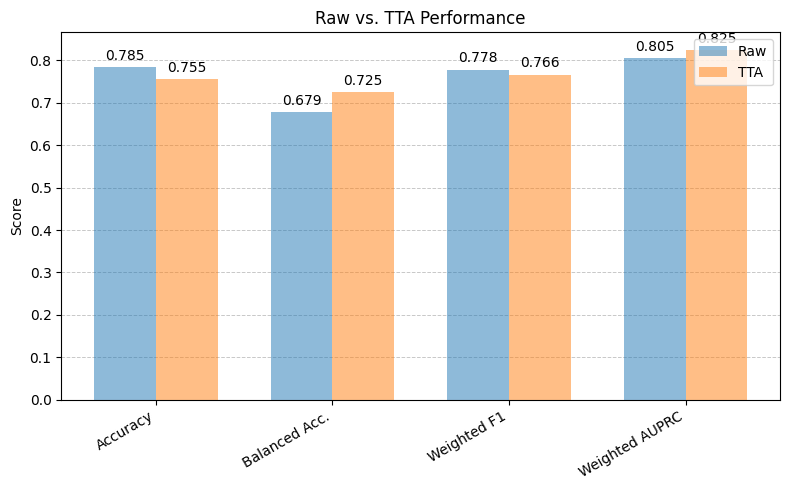

In [ ]:
metrics_full2 = evaluate_with_tta(
    model_full2,
    X_test_full2, y_test_full2,
    batch_size=16
)

## Compare Results

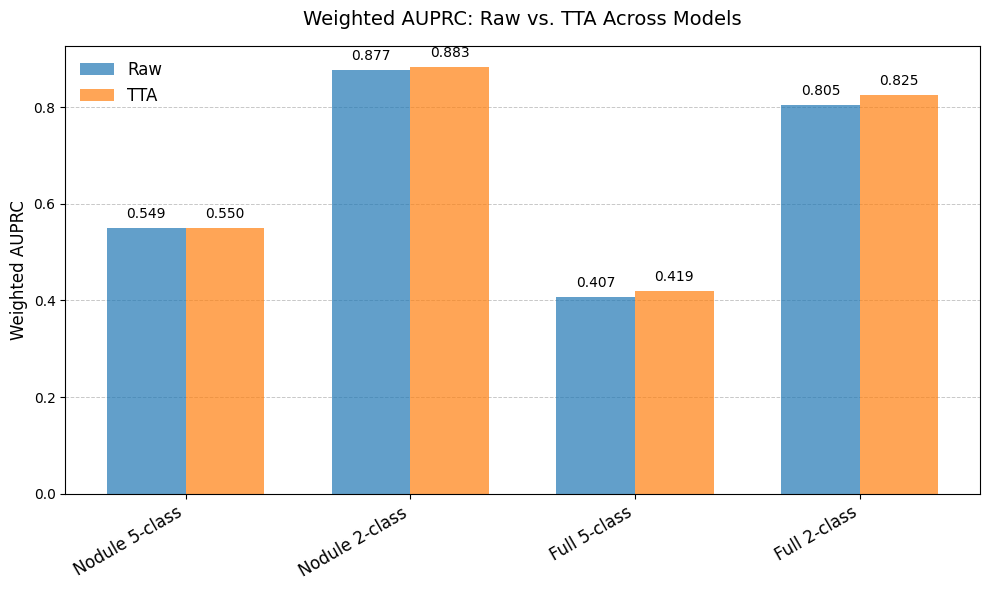

In [ ]:
models = ["Nodule 5-class", "Nodule 2-class", "Full 5-class", "Full 2-class"]

raw_auprc = [
    metrics_nod5["raw"]["weighted_auprc"],
    metrics_nod2["raw"]["weighted_auprc"],
    metrics_full5["raw"]["weighted_auprc"],
    metrics_full2["raw"]["weighted_auprc"],
]
tta_auprc = [
    metrics_nod5["tta"]["weighted_auprc"],
    metrics_nod2["tta"]["weighted_auprc"],
    metrics_full5["tta"]["weighted_auprc"],
    metrics_full2["tta"]["weighted_auprc"],
]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars_raw = ax.bar(x - width/2, raw_auprc, width, label="Raw", alpha=0.7)
bars_tta = ax.bar(x + width/2, tta_auprc, width, label="TTA", alpha=0.7)

# Annotate each bar with its value
for bar in bars_raw + bars_tta:
    h = bar.get_height()
    ax.annotate(f"{h:.3f}",
                xy=(bar.get_x() + bar.get_width()/2, h),
                xytext=(0, 5), textcoords="offset points",
                ha="center", va="bottom", fontsize=10)

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=30, ha="right", fontsize=12)
ax.set_ylabel("Weighted AUPRC", fontsize=12)
ax.set_title("Weighted AUPRC: Raw vs. TTA Across Models", fontsize=14, pad=15)
ax.legend(frameon=False, fontsize=12)
ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()